# Train Vgg + LSTM + Attention

## Setup

In [1]:
# Skip this cell if we are not on Google Colab
try:
    # Mount Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Specify working directory.
    FOLDERNAME = 'cs231n/project/'
    %cd /content/drive/My\ Drive/$FOLDERNAME

    # Ensure that the Python interpreter of the Colab VM can load python files from
    # within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
except ImportError as e:
    print("Not on Google Colab.")

Not on Google Colab.


## Load dataset and labels

In [2]:
import numpy as np
import os

#base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'
base_dir = '/home/ubuntu'

train_data = np.load(os.path.join(base_dir, 'train_data_pre12.npy'))
train_actions = np.load(os.path.join(base_dir, 'train_actions_pre12.npy'), allow_pickle=True)
train_labels = np.load(os.path.join(base_dir, 'train_labels_pre12.npy'))

val_data = np.load(os.path.join(base_dir, 'val_data_pre12.npy'))
val_actions = np.load(os.path.join(base_dir, 'val_actions_pre12.npy'), allow_pickle=True)
val_labels = np.load(os.path.join(base_dir, 'val_labels_pre12.npy'))

In [3]:
print('Training data shape: ', train_data.shape)
print('Training label shape: ', train_labels.shape)
print('Training action shape: ', train_actions.shape)
print('Train Label=1 ratio:', np.sum(train_labels) /train_labels.shape[0])
print('Validation data shape: ', val_data.shape)
print('Validation label shape: ', val_labels.shape)
print('Validation action shape: ', val_actions.shape)
print('Validation Label=1 ratio:', np.sum(val_labels) / val_labels.shape[0])

Training data shape:  (1007, 12, 224, 224, 3)
Training label shape:  (1007,)
Training action shape:  (1007,)
Train Label=1 ratio: 0.24925521350546176
Validation data shape:  (433, 12, 224, 224, 3)
Validation label shape:  (433,)
Validation action shape:  (433,)
Validation Label=1 ratio: 0.2517321016166282


In [4]:
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
train_action_labels = [mapping[x] for x in train_actions]
val_action_labels = [mapping[x] for x in val_actions]

# One-hot encoding.
train_action_labels = np.eye(8)[train_action_labels] 
val_action_labels = np.eye(8)[val_action_labels] 

## 1. VGG + LSTM Model

### 1.1 Define model

In [5]:
from keras.layers import Permute, multiply, Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import models, Model
from keras.applications import vgg16

frames, channels, rows, columns = 12, 3, 224, 224
#Pre-trained VGG
model = models.Sequential()
model.add(Input(shape=(frames, rows, columns, channels)))

model.add(TimeDistributed(vgg16.VGG16(input_shape=(rows,columns,channels),
                 weights="imagenet",
                 include_top=False)))

for layer in model.layers:
    layer.trainable = False

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.2))
#LSTM:
model.add(LSTM(64, dropout=0.25, recurrent_dropout=0.1, return_sequences=False)) # used 64 units
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) # n_labels = 8
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 25088)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 25088)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                6439168   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

In [7]:
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=50),
                  keras.callbacks.ModelCheckpoint(
                      filepath='vgg_lstm_clean_v1',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=50
                  )]

from keras import optimizers

optimizer_new=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                              decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### 1.2 Train model

In [8]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=20, epochs=200,
                    callbacks=callbacks_list
                    )

Epoch 1/200
51/51 [==============================] - 301s 5s/step - loss: 2.1187 - accuracy: 0.1453 - val_loss: 2.0733 - val_accuracy: 0.1432
INFO:tensorflow:Assets written to: vgg_lstm_clean_v1/assets
Epoch 2/200
51/51 [==============================] - 154s 3s/step - loss: 2.0739 - accuracy: 0.1399 - val_loss: 2.0809 - val_accuracy: 0.1178
Epoch 3/200
51/51 [==============================] - 123s 2s/step - loss: 2.0708 - accuracy: 0.1648 - val_loss: 2.0743 - val_accuracy: 0.1293
Epoch 4/200
51/51 [==============================] - 124s 2s/step - loss: 2.0645 - accuracy: 0.1557 - val_loss: 2.0570 - val_accuracy: 0.1594
INFO:tensorflow:Assets written to: vgg_lstm_clean_v1/assets
Epoch 5/200
51/51 [==============================] - 124s 2s/step - loss: 2.0531 - accuracy: 0.1674 - val_loss: 2.0406 - val_accuracy: 0.1894
INFO:tensorflow:Assets written to: vgg_lstm_clean_v1/assets
Epoch 6/200
51/51 [==============================] - 124s 2s/step - loss: 2.0359 - accuracy: 0.2055 - val_loss

51/51 [==============================] - 126s 2s/step - loss: 1.1252 - accuracy: 0.6327 - val_loss: 1.4794 - val_accuracy: 0.4480
Epoch 47/200
51/51 [==============================] - 126s 2s/step - loss: 1.1975 - accuracy: 0.5775 - val_loss: 1.4051 - val_accuracy: 0.4873
INFO:tensorflow:Assets written to: vgg_lstm_clean_v1/assets
Epoch 48/200
51/51 [==============================] - 126s 2s/step - loss: 1.0986 - accuracy: 0.6184 - val_loss: 1.3990 - val_accuracy: 0.5012
INFO:tensorflow:Assets written to: vgg_lstm_clean_v1/assets
Epoch 49/200
51/51 [==============================] - 126s 2s/step - loss: 1.1184 - accuracy: 0.6143 - val_loss: 1.3682 - val_accuracy: 0.5219
INFO:tensorflow:Assets written to: vgg_lstm_clean_v1/assets
Epoch 50/200
51/51 [==============================] - 126s 2s/step - loss: 1.0570 - accuracy: 0.6394 - val_loss: 1.3178 - val_accuracy: 0.5012
INFO:tensorflow:Assets written to: vgg_lstm_clean_v1/assets
Epoch 51/200
51/51 [==============================] - 125s

Epoch 96/200
51/51 [==============================] - 124s 2s/step - loss: 0.4412 - accuracy: 0.8746 - val_loss: 1.0904 - val_accuracy: 0.6028
Epoch 97/200
51/51 [==============================] - 124s 2s/step - loss: 0.4545 - accuracy: 0.8752 - val_loss: 1.0831 - val_accuracy: 0.6005
Epoch 98/200
51/51 [==============================] - 124s 2s/step - loss: 0.4167 - accuracy: 0.8784 - val_loss: 1.0766 - val_accuracy: 0.6143
Epoch 99/200
51/51 [==============================] - 124s 2s/step - loss: 0.4532 - accuracy: 0.8623 - val_loss: 1.0354 - val_accuracy: 0.6259
INFO:tensorflow:Assets written to: vgg_lstm_clean_v1/assets
Epoch 100/200
51/51 [==============================] - 124s 2s/step - loss: 0.4229 - accuracy: 0.8861 - val_loss: 1.0599 - val_accuracy: 0.6120
Epoch 101/200
51/51 [==============================] - 124s 2s/step - loss: 0.4100 - accuracy: 0.8698 - val_loss: 1.0595 - val_accuracy: 0.6143
Epoch 102/200
51/51 [==============================] - 124s 2s/step - loss: 0.39

51/51 [==============================] - 127s 3s/step - loss: 0.2085 - accuracy: 0.9371 - val_loss: 1.0994 - val_accuracy: 0.6467
Epoch 151/200
51/51 [==============================] - 127s 3s/step - loss: 0.1572 - accuracy: 0.9693 - val_loss: 0.9995 - val_accuracy: 0.6836
Epoch 152/200
51/51 [==============================] - 127s 3s/step - loss: 0.1463 - accuracy: 0.9679 - val_loss: 1.2606 - val_accuracy: 0.6259
Epoch 153/200
51/51 [==============================] - 127s 3s/step - loss: 0.1574 - accuracy: 0.9661 - val_loss: 1.1508 - val_accuracy: 0.6351
Epoch 154/200
51/51 [==============================] - 127s 2s/step - loss: 0.1540 - accuracy: 0.9604 - val_loss: 1.0625 - val_accuracy: 0.6674
Epoch 155/200
51/51 [==============================] - 127s 3s/step - loss: 0.1709 - accuracy: 0.9599 - val_loss: 1.2353 - val_accuracy: 0.6305
Epoch 156/200
51/51 [==============================] - 127s 2s/step - loss: 0.1692 - accuracy: 0.9491 - val_loss: 1.0594 - val_accuracy: 0.6490
Epoch 

### 1.3 Visualize Train/Valid accuracy & loss, confusion matrix

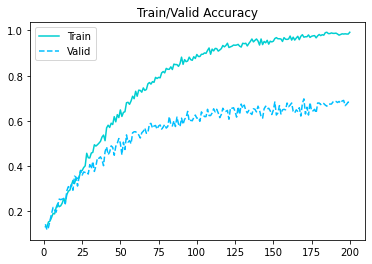

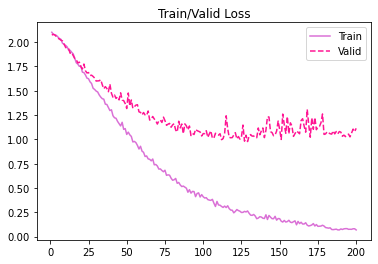

In [9]:
###Plot train/valid accuracy & loss
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkturquoise')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'deepskyblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'orchid')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'deeppink')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

In [10]:
import keras
# Predictions on validation data:
val_preds = model.predict(val_data)
val_preds = np.argmax(val_preds,axis=1)
val_true = [mapping[x] for x in val_actions]

<AxesSubplot:>

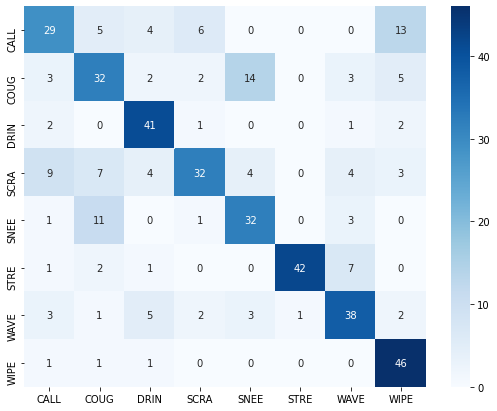

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [13]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

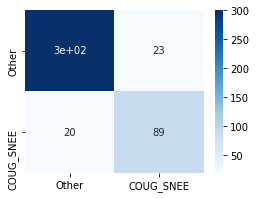

In [14]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [15]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.7946428571428571
Rec.% 0.8165137614678899
Acc.% 0.6742424242424242


### 1.4 Save model and loss history

In [11]:
###Save history
np.save(os.path.join(base_dir, "vgg_lstm_clean_v1_history"), history.history)
###Save model
model.save(os.path.join(base_dir, "vgg_lstm_clean_v1.h5"))   

#Load history:
#history = np.load(os.path.join(base_dir, "mvgg_lstm_clean_v1_history.npy"), allow_pickle=True)

#Load saved model:
#model = keras.models.load_model(os.path.join(base_dir, "vgg_lstm_clean_v1.h5"))

### 1.5 Evaluation on test data

In [16]:
#Load Test Data:
base_dir = '/home/ubuntu'
test_data = np.load(os.path.join(base_dir, 'test_data_pre12.npy'))
test_actions = np.load(os.path.join(base_dir, 'test_actions_pre12.npy'), allow_pickle=True)


In [17]:
# Predictions on test data:
test_preds = model.predict(test_data)
test_preds = np.argmax(test_preds,axis=1)
test_true = [mapping[x] for x in test_actions]

<AxesSubplot:>

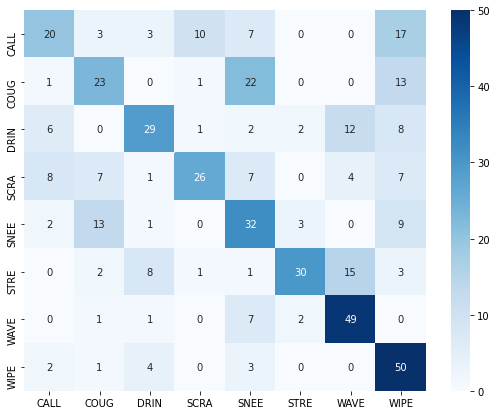

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [19]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

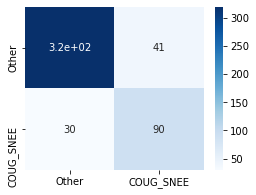

In [20]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [21]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.6870229007633588
Rec.% 0.75
Acc.% 0.5590062111801242


## 2. VGG + LSTM + Attention Model

### 2.1 Define model

In [5]:
from keras.layers import Permute, multiply, Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import models, Model
from keras.applications import vgg16
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

frames, channels, rows, columns = 12, 3, 224, 224
#Pre-trained VGG
model = models.Sequential()
model.add(Input(shape=(frames, rows, columns, channels)))

model.add(TimeDistributed(vgg16.VGG16(input_shape=(rows,columns,channels),
                 weights="imagenet",
                 include_top=False)))

for layer in model.layers:
    layer.trainable = False

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.2))
#LSTM:
model.add(LSTM(64, dropout=0.25, recurrent_dropout=0.1, return_sequences=True)) # used 64 units
#Self-attention
model.add(SeqWeightedAttention())
#model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) # n_labels = 8
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 25088)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 25088)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 12, 64)            6439168   
_________________________________________________________________
seq_weighted_attention (SeqW (None, 64)                65        
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2

In [7]:
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=50),
                  keras.callbacks.ModelCheckpoint(
                      filepath='vgg_lstm_attn_clean_v1',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=50
                  )]

from keras import optimizers

optimizer_new=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                              decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### 2.2 Train model

In [8]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=20, epochs=200,
                    callbacks=callbacks_list
                    )

Epoch 1/200
51/51 [==============================] - 321s 5s/step - loss: 2.1323 - accuracy: 0.1302 - val_loss: 2.0434 - val_accuracy: 0.1755
INFO:tensorflow:Assets written to: vgg_lstm_attn_clean_v1/assets
Epoch 2/200
51/51 [==============================] - 142s 3s/step - loss: 2.0538 - accuracy: 0.1737 - val_loss: 2.0260 - val_accuracy: 0.1963
INFO:tensorflow:Assets written to: vgg_lstm_attn_clean_v1/assets
Epoch 3/200
51/51 [==============================] - 125s 2s/step - loss: 2.0248 - accuracy: 0.1889 - val_loss: 2.0374 - val_accuracy: 0.1824
Epoch 4/200
51/51 [==============================] - 125s 2s/step - loss: 2.0342 - accuracy: 0.2052 - val_loss: 2.0112 - val_accuracy: 0.2009
INFO:tensorflow:Assets written to: vgg_lstm_attn_clean_v1/assets
Epoch 5/200
51/51 [==============================] - 125s 2s/step - loss: 2.0259 - accuracy: 0.1926 - val_loss: 1.9886 - val_accuracy: 0.2402
INFO:tensorflow:Assets written to: vgg_lstm_attn_clean_v1/assets
Epoch 6/200
51/51 [===========

51/51 [==============================] - 125s 2s/step - loss: 1.0302 - accuracy: 0.6299 - val_loss: 1.2701 - val_accuracy: 0.5381
INFO:tensorflow:Assets written to: vgg_lstm_attn_clean_v1/assets
Epoch 45/200
51/51 [==============================] - 125s 2s/step - loss: 1.0308 - accuracy: 0.6505 - val_loss: 1.2536 - val_accuracy: 0.5289
INFO:tensorflow:Assets written to: vgg_lstm_attn_clean_v1/assets
Epoch 46/200
51/51 [==============================] - 125s 2s/step - loss: 1.0230 - accuracy: 0.6456 - val_loss: 1.2218 - val_accuracy: 0.5612
INFO:tensorflow:Assets written to: vgg_lstm_attn_clean_v1/assets
Epoch 47/200
51/51 [==============================] - 125s 2s/step - loss: 0.9740 - accuracy: 0.6593 - val_loss: 1.2725 - val_accuracy: 0.5381
Epoch 48/200
51/51 [==============================] - 124s 2s/step - loss: 0.9988 - accuracy: 0.6645 - val_loss: 1.2270 - val_accuracy: 0.5404
Epoch 49/200
51/51 [==============================] - 124s 2s/step - loss: 0.9470 - accuracy: 0.6795 - 

Epoch 95/200
51/51 [==============================] - 125s 2s/step - loss: 0.3175 - accuracy: 0.8930 - val_loss: 0.9420 - val_accuracy: 0.6513
Epoch 96/200
51/51 [==============================] - 125s 2s/step - loss: 0.2690 - accuracy: 0.9377 - val_loss: 0.9465 - val_accuracy: 0.6767
Epoch 97/200
51/51 [==============================] - 125s 2s/step - loss: 0.2798 - accuracy: 0.9364 - val_loss: 0.9215 - val_accuracy: 0.6697
Epoch 98/200
51/51 [==============================] - 125s 2s/step - loss: 0.2946 - accuracy: 0.9299 - val_loss: 0.9080 - val_accuracy: 0.6905
INFO:tensorflow:Assets written to: vgg_lstm_attn_clean_v1/assets
Epoch 99/200
51/51 [==============================] - 125s 2s/step - loss: 0.2623 - accuracy: 0.9380 - val_loss: 0.9900 - val_accuracy: 0.6397
Epoch 100/200
51/51 [==============================] - 125s 2s/step - loss: 0.2869 - accuracy: 0.9179 - val_loss: 0.9816 - val_accuracy: 0.6420
Epoch 101/200
51/51 [==============================] - 125s 2s/step - loss: 

51/51 [==============================] - 124s 2s/step - loss: 0.0795 - accuracy: 0.9863 - val_loss: 1.0650 - val_accuracy: 0.6790
Epoch 151/200
51/51 [==============================] - 124s 2s/step - loss: 0.1171 - accuracy: 0.9632 - val_loss: 0.9960 - val_accuracy: 0.6744
Epoch 152/200
51/51 [==============================] - 125s 2s/step - loss: 0.0992 - accuracy: 0.9747 - val_loss: 1.0782 - val_accuracy: 0.6674
Epoch 153/200
51/51 [==============================] - 125s 2s/step - loss: 0.1003 - accuracy: 0.9726 - val_loss: 0.9855 - val_accuracy: 0.7090
Epoch 154/200
51/51 [==============================] - 125s 2s/step - loss: 0.1082 - accuracy: 0.9838 - val_loss: 1.0927 - val_accuracy: 0.6559
Epoch 155/200
51/51 [==============================] - 125s 2s/step - loss: 0.4686 - accuracy: 0.8478 - val_loss: 0.9472 - val_accuracy: 0.6975
Epoch 156/200
51/51 [==============================] - 125s 2s/step - loss: 0.2070 - accuracy: 0.9423 - val_loss: 1.0064 - val_accuracy: 0.7044
Epoch 

### 2.3 Visualize Train/Valid accuracy & loss, confusion matrix

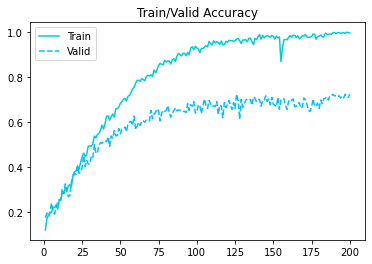

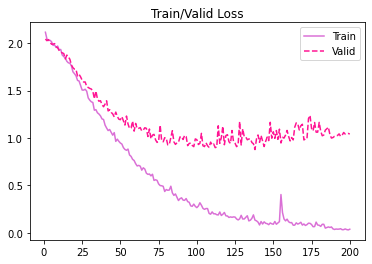

In [10]:
###Plot train/valid accuracy & loss
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkturquoise')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'deepskyblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'orchid')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'deeppink')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

In [11]:
import keras
# Predictions on validation data:
val_preds = model.predict(val_data)
val_preds = np.argmax(val_preds,axis=1)
val_true = [mapping[x] for x in val_actions]

<AxesSubplot:>

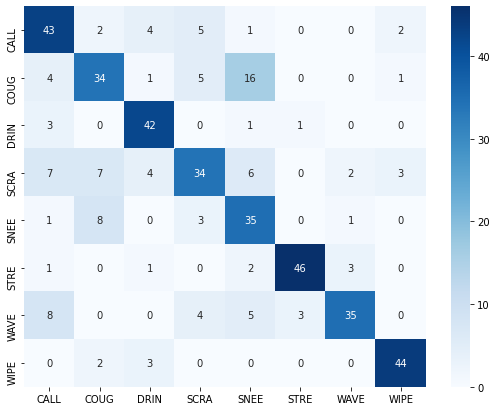

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [13]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

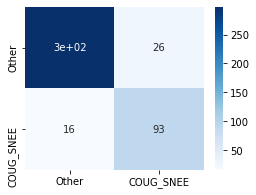

In [14]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [15]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.7815126050420168
Rec.% 0.8532110091743119
Acc.% 0.6888888888888889


### 2.4 Save model and loss history

In [9]:
###Save history
np.save(os.path.join(base_dir, "vgg_lstm_attn_clean_v1_history"), history.history)
###Save model
model.save(os.path.join(base_dir, "vgg_lstm_attn_clean_v1.h5"))   

#Load history:
#history = np.load(os.path.join(base_dir, "mvgg_lstm_attn_clean_v1_history.npy"), allow_pickle=True)

#Load saved model:
#model = keras.models.load_model(os.path.join(base_dir, "vgg_lstm_attn_clean_v1.h5"))

### 2.5 Evaluation on test data

In [16]:
#Load Test Data:
base_dir = '/home/ubuntu'
test_data = np.load(os.path.join(base_dir, 'test_data_pre12.npy'))
test_actions = np.load(os.path.join(base_dir, 'test_actions_pre12.npy'), allow_pickle=True)

In [17]:
# Predictions on test data:
test_preds = model.predict(test_data)
test_preds = np.argmax(test_preds,axis=1)
test_true = [mapping[x] for x in test_actions]

<AxesSubplot:>

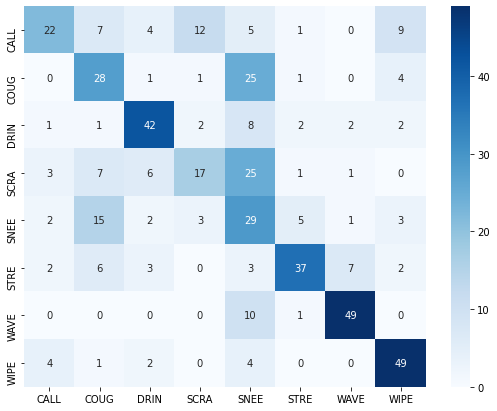

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [19]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

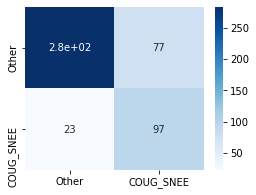

In [20]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [21]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.5574712643678161
Rec.% 0.8083333333333333
Acc.% 0.49238578680203043


### 2.6 Compare Train/Valid Accuracy, Loss for both modles

In [30]:
#load model history
history_with_attn = np.load(os.path.join(base_dir, "vgg_lstm_attn_clean_v1_history.npy"), allow_pickle=True)
history_no_attn = np.load(os.path.join(base_dir, "vgg_lstm_clean_v1_history.npy"), allow_pickle=True)

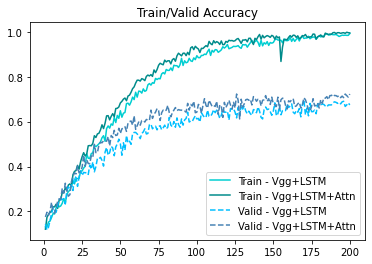

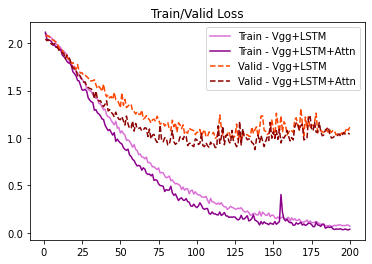

In [31]:
###Plot train/valid accuracy & loss
import matplotlib.pyplot as plt

#no attention
acc=history_no_attn.item()["accuracy"]
val_acc=history_no_attn.item()["val_accuracy"]
loss=history_no_attn.item()["loss"]
val_loss=history_no_attn.item()["val_loss"]

#with attention
acc_attn=history_with_attn.item()["accuracy"]
val_acc_attn=history_with_attn.item()["val_accuracy"]
loss_attn=history_with_attn.item()["loss"]
val_loss_attn=history_with_attn.item()["val_loss"]

epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train - Vgg+LSTM", color = 'darkturquoise')
plt.plot(epochs, acc_attn, label = "Train - Vgg+LSTM+Attn", color = 'darkcyan')
plt.plot(epochs, val_acc, label = "Valid - Vgg+LSTM", linestyle="--", color = 'deepskyblue')
plt.plot(epochs, val_acc_attn, label = "Valid - Vgg+LSTM+Attn", linestyle="--", color = 'steelblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train - Vgg+LSTM", color = 'orchid')
plt.plot(epochs, loss_attn, label = "Train - Vgg+LSTM+Attn", color = 'darkmagenta')
plt.plot(epochs, val_loss, label = "Valid - Vgg+LSTM", linestyle="--", color = 'orangered')
plt.plot(epochs, val_loss_attn, label = "Valid - Vgg+LSTM+Attn", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

## Summary

* **Vgg + LSTM**:
    - Model file: vgg_lstm_clean_v1.h5
    - Loss history: vgg_lstm_clean_v1_history.npy
    
* **Vgg + LSTM + Attention**:
    - Model file: vgg_lstm_attn_clean_v1.h5
    - Loss history: vgg_lstm_attn_clean_v1_history.npy